# Los modelos de RNN
>RNN o modelos recurrentes tienen una estructura que primero, tiene la tipica estructura de MLP, sin embargo, al pasar un instante, la capa oculta se vuelve dependiente de la entrada en el tiempo anterior y de la capa oculta anterior
> Estos modelos aprenden secuencias del conjunto de datos atraves de la capas ocultas en el tiempo
> Es un modelo que se podría decir que es recursivo al iterar en el tiempo
> 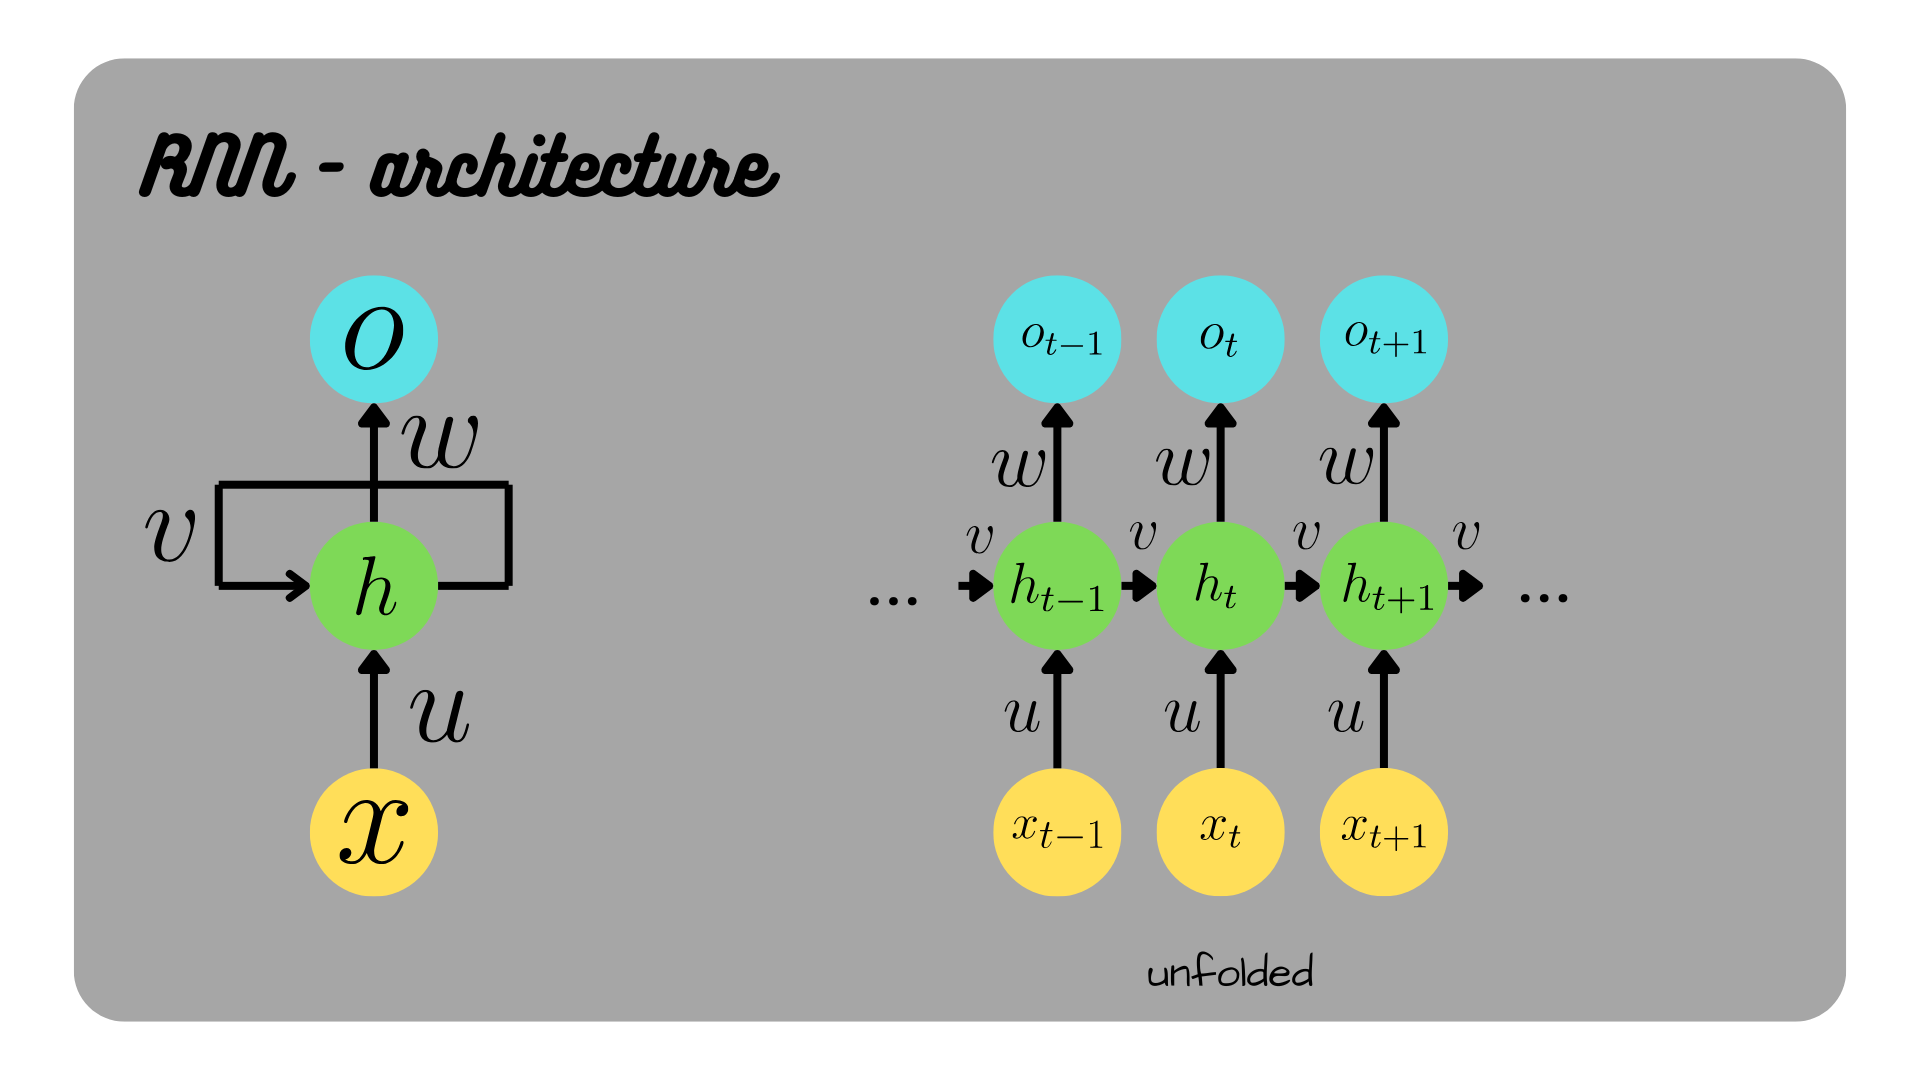
> Para esto, existe entonces el Backpropagation atraves del tiempo, despues se ve que el problema que tiene es que a cosas de largo tiempo se olvida

In [71]:
import torch.nn as nn
import torch.nn.functional as F
import torch
class ElmanRNN(nn.Module):
    def __init__ (self,input_size,hidden_size, batch_first=False):
        """
        Implementación de una celula, que corresponde a solo un instante del tiempo
        Args :
            input_size: tamaño de los vectores de entrada
            hidden_size: tamaño de los vectores de estado
            batch_first: si la 0 dimension es batch
        """
        super(ElmanRNN,self).__init__()
        self.rnn_cell=nn.RNNCell(input_size,hidden_size)
        self.hidden_size=hidden_size
        self.batch_first= batch_first
    def _initialize_hidden(self,batch_size):
        return torch.zeros((batch_size,self.hidden_size))
    def forward(self,x_in, initial_hidden=None):
        """ El paso hacia adelante de la ElmanRNN
        args:
        x_in (torch.Tensor): an input data tensor.
        if self.batch_first: x_in.shape= (batch_size,seq_size,feat_Size)
        else:
        x_in.shape= (seq_size,feat_size)
        initial_hidden torch.tensor: The initial hidden state for the RNN
        Returns:
            hiddens(torch.tensor): the output of the RNN at ach time step.
            if self.batch_first:
            hiddens.shape = (batch_size, seq_size, hidden_size)
        else: hiddens.shape = (seq_size, batch_size, hidden_size)
        """
        if self.batch_first:
            batch_size,seq_size,feat_size=x_in.size()
            x_in=x_in.permute(1,0,2)
        else:
            seq_size,batch_size,feat_size=x_in.size()
        hiddens=[]
        if initial_hidden is None:
            initial_hidden=self._initialize_hidden(batch_size)
            initial_hidden= initial_hidden.to(x_in.device)
        hidden_t= initial_hidden
        for t in range(seq_size):
            hidden_t = self.rnn_cell(x_in[t],hidden_t)
            hiddens.append(hidden_t)
        hiddens= torch.stack(hiddens)

        if self.batch_first:
            hiddens= hiddens.permute(1,0,2)
        return hiddens

In [72]:
import pandas as pd
import torch
import numpy as np
class Vocabulary(object):
    """ Clase a procesar texto y extrar el vocabulario para mappear"""
    def __init__(self,token_to_idx=None,add_unk=True,unk_token="<UNK>"):
        """Args:
            token_to_idx (dict): un mapa pre existen de toknes a indices
            add_unk(bool): un bandera que indica si se añade el token UNK de desconocido
            unk_token(str): el token UNK se añade a el vocabulario
            """
        if token_to_idx is None:
            token_to_idx={}
        self._token_to_idx=token_to_idx
        self._idx_to_token={idx: token
                           for token,idx in self._token_to_idx.items()}
        self._add_unk=add_unk
        self._unk_token=unk_token
        self.unk_index=-1
        if add_unk:
            self.unk_index=self.add_token(unk_token)
    def to_serializable(self):
        """ Retorna un diccionario que puede ser serializado """
        return {"token_to_idx":self._token_to_idx,
               "add_unk":self._add_unk,
               "unk_token":self._unk_token}
    @classmethod
    def from_serializable(cls,contents):
        """instancia el bocabulario desde un diccionario serializado"""
        return cls(**contents)
    def add_token(self,token):
        """
        Actualiza los mapeos de diccionarrios basados en los tokens
        Args:
            token (str): el item a añadir en el vocabulario
        Returns:
            index(int) : el entero correspondiente al token
        """
        if token in self._token_to_idx:
            index=self._token_to_idx[token]
        else:
            index=len(self._token_to_idx)
            self._token_to_idx[token]=index
            self._idx_to_token[index]=token
        return index
    def lookup_token(self,token):
        """ Obtiene el indice asociado con el tokenn de UNK token si el token no está presente,
        Args:
            token (str): el token a observar
        returns :
            index (int) el indices correspondiente al token
        Notes:
               `unk_index` necesita ser entero positivo (habiendo sido añadido al vocabulario) para la funcionalidad desconocidad
               """
        if self._add_unk:
            return self._token_to_idx.get(token,self.unk_index)
        else:
            return self._token_to_idx[token]
    def lookup_index(self,index):
        """ Obtiene el token asociado al indice
        Args:
            index (int): el indice a observar
        returns :
            token (str) el token correspondiendte al indices
        Raises:
            KeyError: si el indice no está en el vocabulario
        """
        if index not in self._idx_to_token:
            raise KeyError("El indice (%d)no está en el vocabulario" % index)
        return self._idx_to_token[index]
    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)
    def __len__(self):#Refleja la longitudad del vocabulario
        return len(self._token_to_idx)

In [73]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [74]:
from collections import Counter
import string
class SurnameVectorizer(object):
    """ La clase vectorizer de las cuales, suss coordenadas son las del vocabulario"""
    def __init__(self,char_vocab,nationality_vocab):
        """
        Args:
            char_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
        """
        self.char_vocab = char_vocab
        self.nationality_vocab = nationality_vocab
    def vectorize(self, surname, vector_length=-1):
        """
        Args:
            title (str): the string of words separated by a space
            vector_length (int): an argument for forcing the length of index vector
        Returns:
            the vetorized title (numpy.array)
        """
        indices = [self.char_vocab.begin_seq_index]
        indices.extend(self.char_vocab.lookup_token(token) 
                       for token in surname)
        indices.append(self.char_vocab.end_seq_index)
        
        if vector_length < 0:
            vector_length = len(indices)
        
        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.char_vocab.mask_index
        
        return out_vector,len(indices)

    @classmethod
    def from_dataframe(cls, surname_df, ):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            news_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the NewsVectorizer
        """
        char_vocab = SequenceVocabulary()
        nationality_vocab=Vocabulary()
        for index,row in surname_df.iterrows():
            for char in row.surname:
                char_vocab.add_token(char)
            nationality_vocab.add_token(row.nationality)
        return cls(char_vocab,nationality_vocab)
    @classmethod 
    def from_serializable(cls, contents):
        char_vocab = SequenceVocabulary.from_serializable(contents['char_vocab'])
        nat_vocab =  Vocabulary.from_serializable(contents['nationality_vocab'])

        return cls(char_vocab=char_vocab, nationality_vocab=nat_vocab)

    def to_serializable(self):
        return {'char_vocab': self.char_vocab.to_serializable(), 
                'nationality_vocab': self.nationality_vocab.to_serializable()}


In [75]:

from torch.utils.data import Dataset
class SurnameDataset(Dataset):
    # Se hereda la clase Dataset
    def __init__(self,surname_df,vectorizer):
        """
        Args:
            review_df(pandas.DataFrame): El conjunto de datos
            vectorizer(ReviewVectorizer): vectorizer instacinado desde el conjunto de datos
        """
        self.surname_df = surname_df
        
        self._max_seq_length = max(map(len, self.surname_df.surname)) + 2
        self._vectorizer = vectorizer
        self.train_df= self.surname_df[self.surname_df.split=="train"]
        self.train_size=len(self.train_df)

        self.val_df= self.surname_df[self.surname_df.split=="val"]
        self.val_size=len(self.val_df)

        self.test_df= self.surname_df[self.surname_df.split=="test"]
        self.test_size=len(self.test_df)

        self._lookup_dic={'train':(self.train_df,self.train_size),
                         'val':(self.val_df,self.val_size),
                         'test':(self.test_df,self.test_size),
                         }
        self.set_split("train")
        class_counts = surname_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
    @classmethod
    def load_dataset_and_make_vectorizer(cls,review_cls):
        """
        carga el dataset y hacer un nuevo vectorizador desde cero
        args:
                review_cvs(str): ubicacion del dataset
        Returns:
            una instancia de ReviewDataset
        """
        surname_df= pd.read_csv(review_cls)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df,SurnameVectorizer.from_dataframe(train_surname_df))
    def get_vectorizer(self):
        """retorna el vectorizador"""
        return self._vectorizer
    def set_split(self,split="train"):
        """
        Selecciona la division en el conjunto de datos usando una columna en el dataframe
        args:
        split(str):  uno de "train","val","test"
        """
        self._target_split=split
        self._target_df,self._target_size=self._lookup_dic[split]
    def __len__(self):
        return self._target_size
    def __getitem__(self,index):
        """
        El punto primario de entrada como metodo para PyTorch en lso conjuntos de datos
        Args:
        index(int): Es el inice del dato
        Returns:
            Diccionario de las caracterizitcads de los puntos de datos y labels
        """
        row=self._target_df.iloc[index]
        surname_vector, vec_length=self._vectorizer.vectorize(row.surname,self._max_seq_length)
        nationality_index=self._vectorizer.nationality_vocab.lookup_token(row.nationality)
        return {'x_data':surname_vector,
                'y_data':nationality_index,
               'x_length':vec_length}
    def get_num_batches(self,batch_size):
        """
        Dado un tamaño de batch , retorna el numero de batches del conjunto de datos
        Args:
            batch_size(int)
        Returns:
            Numero de batches en el conjuntos
        """
        return len(self)//batch_size

# El modelo De RNN
> Aquí está el ejemplo del modelo compleot de Elmann RNN con varias neuronas m
Este modelo lo que hace, es embeber los enteros  de los vectores de texto con la capa de embedding. Despues se usa el modelo de RNN para hacer una representacion vectorial de estos embeddings, que representa los estados ocultos para cada caacter en el apellido
>
> 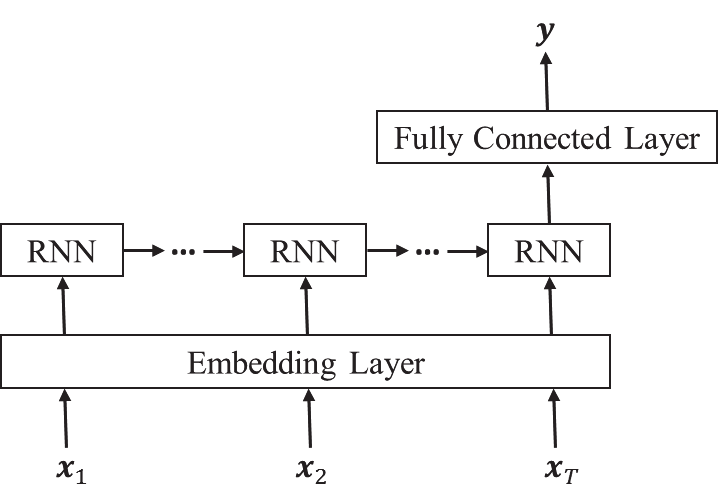

In [110]:

def column_gather(y_out,x_lengths):
    """
        Get a specific vector from each batch dat point in y_out

        Args:
            y_out(torch.FloatTensor, tyorch.cuda.FloatTensor)
        x_lengths (torch.LongTensor, tporch.cuda.LongTesnor)
    Returnsn:
    y_out (torch.FlaotTensor, torch.cudaFloatTensor)
        shape:(batch,feature)
    """
    x_lengths= x_lengths.long().detach().cpu().numpy()-1
    out=[]
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index,column_index])
    return torch.stack(out)

class SurnameClassifier(nn.Module):
    """ el RNN servirar como extractor ded caracteristicas y el MLP como clasificador"""
    def __init__(self,embedding_size, num_embeddings, num_classes,
                 rnn_hidden_size, batch_first=True,padding_idx=0):
        """
            Args:
                embeddings_size(iint): el tamaño del caracter de embeddings
                num_embeddings: el numero de caracteres a embbder
                numero de clases : el tamaño del vector de predicciones
                    Note: el numero de nacionalidades
                rnn_hidden_si<e(int): el tamaño de los estados ocultos de los RNN
                batch_first (bool): informa sila entrada de los tensores tendra un batc o una secuencia en la dimension 0
                padding_idx (nt): el indie para el padding del tensor:
                """
        super(SurnameClassifier,self).__init__()
        self.emb = nn.Embedding(num_embeddings=num_embeddings,
        embedding_dim=embedding_size,
        padding_idx=padding_idx)
        self.rnn= ElmanRNN(input_size=embedding_size,hidden_size=rnn_hidden_size)
        self.fc1=nn.Linear(in_features=rnn_hidden_size,out_features=rnn_hidden_size)
        self.fc2=nn.Linear(in_features=rnn_hidden_size,out_features=num_classes)
    def forward(self,x_in,x_lengths=None, apply_softmax=False):
        """ El paso haci aldenta del clasificador
        Args:
            x_in(torch.Tensor): un dato de tensor de entrada
                x_in.shae debe ser (batch,input_dim)
            x_lengths (torch.Tensor): La longitud de cada secuencia en le batchb usado para encotnrar el vector final de cda secuencia
            apply_softmax(bool): Un bandera para la activacion de la softmax debe ser falssa si se usa con las perdidas de cross-entropy
        Returns:
            out(torch.Tensor): out.shape =(batch,num_classes)
        """
        x_embedded=self.emb(x_in)
        y_out=self.rnn(x_embedded)
        if x_lengths is not None:
            y_out= column_gather(y_out,x_lengths)
        else:
            y_out = y_out[:,-1,:]
        y_out= F.dropout(y_out,0.5)
        y_out= F.relu(self.fc1(y_out))
        y_out = F.dropout(y_out, 0.5)
        y_out = self.fc2(y_out)
        if apply_softmax:
            y_out = F.softmax(y_out,dim=1)
        return y_out

# Entrenamiento
> Teoricamente, siogue el mkismo entrenamiento que previamente ya se ha visto en los anteriores capitulos

In [111]:
from argparse import Namespace
args=Namespace(
    #Datos y direcciones
    cuda=True,
    surname_csv="data/surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="model_storage/ch4/surname_nlp",
    hidden_dim=100,
    num_channels=256,
    # Model hyper parameter
    char_embedding_size=100,
    rnn_hidden_size=64,
   
    seed=1337,
    num_epochs=100,
    early_stopping_criteria=5,
    learning_rate=0.001,
    batch_size=128,
    dropout=0.1
    )
"""
args = Namespace(
    # Data and path information
    surname_csv="data/surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="model_storage/ch6/surname_classification",
    # Training hyper parameter
    num_epochs=100,
    learning_rate=1e-3,
    batch_size=64,
    seed=1337,
    early_stopping_criteria=5,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
)
"""

'\nargs = Namespace(\n    # Data and path information\n    surname_csv="data/surnames/surnames_with_splits.csv",\n    vectorizer_file="vectorizer.json",\n    model_state_file="model.pth",\n    save_dir="model_storage/ch6/surname_classification",\n    # Training hyper parameter\n    num_epochs=100,\n    learning_rate=1e-3,\n    batch_size=64,\n    seed=1337,\n    early_stopping_criteria=5,\n    # Runtime hyper parameter\n    cuda=True,\n    catch_keyboard_interrupt=True,\n    reload_from_files=False,\n    expand_filepaths_to_save_dir=True,\n)\n'

In [112]:
#El conjunto de datos instanciado
import torch.optim as optim
dataset=SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
vectorizer= dataset.get_vectorizer()

classifier = SurnameClassifier(embedding_size=args.char_embedding_size, 
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)
if not torch.cuda.is_available():
    args.cuda=False
args.device= torch.device("cuda" if args.cuda else "cpu")
classifier.to(args.device)


loss_func=nn.CrossEntropyLoss()
optimizer=optim.Adam(classifier.parameters(),lr=args.learning_rate)

In [113]:
def make_train_state(args):
    return { "epoch_index":0,
             "train_loss": [],
             "train_acc":[],
             "val_loss":[],
             "val_acc":[],
             "test_loss":-1,
             "test_acc":-1}
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100
def generate_batches(dataset,batch_size,shuffle=True,
                     drop_last=True,device="cpu"):
    """Una funcion generation la que wrapea ek dataloader de pytorxh. SE asegurarar de que cada tesnor este en un unico dispositivo
    """
    dataloader=DataLoader(dataset=dataset,batch_size=batch_size,shuffle=shuffle,drop_last=drop_last)
    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [114]:
from torch.utils.data import DataLoader
train_state=make_train_state(args)
for epoch_index in range(args.num_epochs):
    train_state['epoch_index']=epoch_index
    # Itera sobre nuestro dataset
    #Configura: el generador de batch, la perdidad, el accuracy a 0 y el conjunto de entrenamiento a activo
    dataset.set_split("train")
    batch_generator=generate_batches(dataset,batch_size=args.batch_size,device=args.device)
    running_loss=0.0
    running_acc=0.0
    classifier.train()
    for batch_index,batch_dict in enumerate(batch_generator):
        
        # La rutina de entrenamiento se conforma de 5 pasos

        #paso 1, los gradientes en cero
        optimizer.zero_grad()
        #Paso . calcula la salida
        y_pred=classifier(batch_dict["x_data"])
        #paso 3, calcula la perdidad
        loss=loss_func(y_pred,batch_dict["y_data"])
        loss_batch=loss.to("cpu").item()
        running_loss+=(loss_batch-running_loss)/(batch_index+1)
        #paso 4, usa la perdidad para producir el gradiente
        loss.backward()
        #Paso 5, usa el otpimizar para que tomo el paso gradiente
        optimizer.step()

        ##Calcula el accuracy
        acc_batch=compute_accuracy(y_pred,batch_dict["y_data"])
        running_acc+=(acc_batch-running_acc)/(batch_index+1)
    train_state["train_loss"].append(running_loss)
    train_state["train_acc"].append(running_acc)

    #Iterar sobre el dataset de validacion
    #Configura, el generator de batch, la perdiddad, el accuracy a 0 y modo eval
    dataset.set_split("val")
    batch_generator=generate_batches(dataset,batch_size=args.batch_size,device=args.device)
    running_loss=0.0
    running_acc=0.0
    classifier.eval()
    #Empieza la evaluacion
    for batch_index,batch_dict in enumerate(batch_generator):
        # Paso 1: calcula la salida
        y_pred=classifier(batch_dict["x_data"])
        # paso 2, calcula la salida
        loss = loss_func(y_pred,batch_dict['y_data'])
        loss_batch = loss.item()
        running_loss += (loss_batch-running_loss)/(batch_index+1)
        #paso 3, calcula el accuracy
        acc_batch= compute_accuracy(y_pred,batch_dict['y_data'])
        running_acc+=(acc_batch-running_acc)/(batch_index+1)
    train_state["val_loss"].append(running_loss)
    train_state["val_acc"].append(running_acc)

In [115]:
dataset.set_split("test")
batch_generator=generate_batches(dataset,batch_size=args.batch_size,device=args.device)
running_loss=0.
running_acc=0.
classifier.eval()
print("comienza la evaluacion")
for batch_index,batch_dict in enumerate(batch_generator):
    print("batch: ",batch_index)
    #Compute the output
    y_pred=classifier(batch_dict["x_data"])
    # calcula la perdidad
    loss = loss_func(y_pred,batch_dict["y_data"])
    loss_batch= loss.item()
    running_loss += (loss_batch-running_loss)/(batch_index+1)
    #Calcula el accuracy 
    acc_batch= compute_accuracy(y_pred,batch_dict["y_data"])
    running_acc+=(acc_batch-running_acc)/(batch_index+1)
train_state["test_loss"]= running_loss
train_state["test_acc"] = running_acc

comienza la evaluacion
batch:  0
batch:  1
batch:  2
batch:  3
batch:  4
batch:  5
batch:  6
batch:  7
batch:  8
batch:  9
batch:  10
batch:  11


In [116]:
print(train_state["test_acc"])

26.888020833333332


In [117]:
def predict_nationality(surname, classifier, vectorizer):
    vectorized_surname, vec_length = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(dim=0)
    vec_length = torch.tensor([vec_length], dtype=torch.int64)
    
    result = classifier(vectorized_surname, vec_length, apply_softmax=True)
    probability_values, indices = result.max(dim=1)
    
    index = indices.item()
    prob_value = probability_values.item()

    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)

    return {'nationality': predicted_nationality, 'probability': prob_value, 'surname': surname}

In [120]:
classifier=classifier.to("cpu")

resultado=predict_nationality("Gonzalez",classifier,vectorizer)
print(resultado)

{'nationality': 'Irish', 'probability': 0.9982553124427795, 'surname': 'Gonzalez'}
